# Consignes

- élaborer deux modèles: l'un à l'aide du package random forest et l'autre à l'aide de XGboost.
    - vous pouvez utiliser un gridsearch si vous savez ce que c'est mais ce n'est pas obligatoire.
- comparer ensuite votre meilleur modèle pour les trois algortihmes étudiés (logistic regression, random forest, Xgboost) à l'aide des courbes ROC et lift
- Tracer la learning curve pour chacuns de ces modèles. 
- étudier l'importance des features de ces trois modèles à l'aide de la librairie SHAP


In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score,precision_score, roc_auc_score, plot_roc_curve

In [3]:
import mlflow
import mlflow.sklearn
from urllib.parse import urlparse

In [4]:
df = pd.read_csv("data/intermediate/Telco_post_analysis.csv")

In [5]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df["Churn"]= le.fit_transform(df["Churn"])

In [6]:
df["Churn"] = LabelEncoder().fit_transform(df["Churn"])
for col in df.drop("customerID",axis=1).columns:
    df[col][(df[col]=="No") | (df[col]=="Male") | (df[col]=="DSL") | (df[col]=="Only Internet")] = 0
    df[col][(df[col]=="Yes") | (df[col]=="Female") | (df[col]=="Fiber optic") | (df[col]=="Phone and Internet")] = 1
    df[col][(df[col]=="No phone service") | (df[col]=="No internet service") | (df[col]=="Only Phone")] = -1
    df[col][df[col] == "Month-to-month"] = 1
    df[col][df[col] == "One year"] = 12
    df[col][df[col] == "Two year"] = 24
    df[col][df[col] == "Mailed check"] = 0
    df[col][df[col] == "Electronic check"] = 1
    df[col][df[col] == "Credit card (automatic)"] = 2
    df[col][df[col] == "Bank transfer (automatic)"] = 3
    df[col] = df[col].astype(float)

C:\Users\APPREN~1\AppData\Local\Temp/ipykernel_12796/3257016833.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][(df[col]=="No") | (df[col]=="Male") | (df[col]=="DSL") | (df[col]=="Only Internet")] = 0
C:\Users\APPREN~1\AppData\Local\Temp/ipykernel_12796/3257016833.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col][(df[col]=="Yes") | (df[col]=="Female") | (df[col]=="Fiber optic") | (df[col]=="Phone and Internet")] = 1
C:\Users\APPREN~1\AppData\Local\Temp/ipykernel_12796/3257016833.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the

In [7]:
features_standard = df.drop(["customerID","Churn"], axis=1).columns
standard_pipeline = make_pipeline(StandardScaler())

preprocessor = make_column_transformer((standard_pipeline,features_standard))

In [11]:
dt = make_pipeline(preprocessor, DecisionTreeClassifier())
rf = make_pipeline(preprocessor, RandomForestClassifier(random_state=1, max_features="log2", min_samples_split=6)
xgb = make_pipeline(preprocessor, XGBClassifier(random_state=1))

In [12]:
X = df.drop(["customerID", "Churn"], axis=1)
y = df.Churn

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [14]:
def eval_metrics(actual, pred):
    accuracy = accuracy_score(actual, pred)
    f1 = f1_score(actual, pred)
    recall = recall_score(actual, pred)
    precision = precision_score(actual, pred)
    auc = roc_auc_score(actual, pred)
    return accuracy, f1, recall, precision, auc

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
param_random_forest = {"randomforestclassifier__class_weight":[{0: 1, 1: 1},{0: 1, 1: 3},{0: 1, 1: 1.5}],
                       "randomforestclassifier__n_estimators":[100,150,200],
                       "randomforestclassifier__criterion": ["gini","entropy"],
                       "randomforestclassifier__max_depth":[None,1,10,15,20,30],
                       "randomforestclassifier__min_samples_split":[2,3,4,5,6,7,8,9],
                       "randomforestclassifier__max_features":["auto","log2"]}
grid_random_forest = GridSearchCV(rf,param_random_forest,scoring='roc_auc')
grid_random_forest.fit(X_train, y_train)
rf = grid_random_forest.best_estimator_

In [21]:
param_xgb = {"xgbclassifier__eta":[0.01,0.05,0.1,0.2,0.3],
             "xgbclassifier__tree_method":["approx","hist","gpu_hist"],
             "xgbclassifier__max_depth":[1,6,10,15,20],
             "xgbclassifier__gamma":[1,3,5,10],
             "xgbclassifier__use_label_encoder": [False]}
grid_xgb = GridSearchCV(xgb,param_xgb,scoring='roc_auc')
grid_xgb.fit(X_train, y_train)
xgb = grid_xgb.best_estimator_

[15:35:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:35:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:35:13] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:35:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

C:\Users\Apprenant\anaconda3\envs\rb_ds\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
500 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Apprenant\anaconda3\envs\rb_ds\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Apprenant\anaconda3\envs\rb_ds\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "C:\Users\Apprenant\anaconda3\envs\rb_ds\lib\site-packages\xgboost\core.py", line 506, in inner_f
    ret

In [ ]:
mlflow.sklearn.autolog()

with mlflow.start_run(experiment_id = 1):
    model = dt.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    accuracy, f1, recall, precision, auc = eval_metrics(y_test, y_pred)
    print("  accuracy: %s" % accuracy)
    print("  f1: %s" % f1)
    print("  recall: %s" % recall) 
    print("  precision: %s" % precision) 
    print("  auc: %s" % auc) 

    mlflow.log_param("Variables", X_test.columns)
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(dt, "model", registered_model_name="decision_tree")
    else:
        mlflow.sklearn.log_model(dt, "model") 
plot_roc_curve(model, X_test, y_test)

In [ ]:
with mlflow.start_run(experiment_id = 1):
    model = rfc.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    accuracy, f1, recall, precision, auc = eval_metrics(y_test, y_pred)
    print("  accuracy: %s" % accuracy)
    print("  f1: %s" % f1)
    print("  recall: %s" % recall) 
    print("  precision: %s" % precision) 
    print("  auc: %s" % auc) 

    mlflow.log_param("Variables", X_test.columns)
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(rfc, "model", registered_model_name="random_forest_classifier")
    else:
        mlflow.sklearn.log_model(rfc, "model") 
plot_roc_curve(model, X_test, y_test)

[15:58:07] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
  accuracy: 0.8024164889836531
  f1: 0.5749235474006117
  recall: 0.5136612021857924
  precision: 0.6527777777777778
  auc: 0.7087998614195052


C:\Users\Apprenant\anaconda3\envs\rb_ds\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


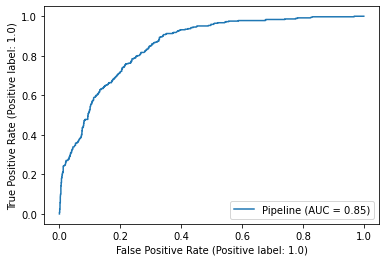

In [24]:
with mlflow.start_run(experiment_id = 1):
    model = xgb.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    accuracy, f1, recall, precision, auc = eval_metrics(y_test, y_pred)
    print("  accuracy: %s" % accuracy)
    print("  f1: %s" % f1)
    print("  recall: %s" % recall) 
    print("  precision: %s" % precision) 
    print("  auc: %s" % auc) 

    mlflow.log_param("Variables", X_test.columns)
    
    tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

    if tracking_url_type_store != "file":
        mlflow.sklearn.log_model(xgb, "model", registered_model_name="xgboost")
    else:
        mlflow.sklearn.log_model(xgb, "model")
plot_roc_curve(model, X_test, y_test)